# Sports Image Classification using ResNet-50

### Step 1: Import Libraries

In [2]:
# Step 1: Import Libraries and Set Device
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models import ResNet50_Weights
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


### Step 2: File Paths and Data Loading

In [21]:
# Step 2: Load the CSV file with image labels

train_csv_path = 'dataset/train.csv'
img_folder = 'dataset/train'  # Use this for all splits (no separate test folder!)

df = pd.read_csv(train_csv_path)
print("First few rows of training CSV:")
print(df.head())
print("Number of total images in the dataset:", len(df))

First few rows of training CSV:
         image_ID      label
0  7c225f7b61.jpg  Badminton
1         b31.jpg  Badminton
2  acb146546c.jpg  Badminton
3  0e62f4d8f2.jpg  Badminton
4  cfd2c28c74.jpg    Cricket
Number of total images in the dataset: 8227


### Step 3: Custom Dataset Class (Handles String Labels)

In [22]:
class SportsDataset(Dataset):
    def __init__(self, csv_file, img_folder, transform=None, is_test=False):
        if isinstance(csv_file, pd.DataFrame):
            self.data = csv_file.reset_index(drop=True)
        else:
            self.data = pd.read_csv(csv_file)
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test

        # Build label-to-index map if not test set
        if not is_test:
            labels = self.data.iloc[:, 1]
            if labels.dtype == 'O' or isinstance(labels.iloc[0], str):
                self.label_names = sorted(labels.unique())
                self.label2idx = {label: idx for idx, label in enumerate(self.label_names)}
                self.idx2label = {idx: label for label, idx in self.label2idx.items()}
            else:
                self.label_names = sorted(labels.unique())
                self.label2idx = {label: label for label in self.label_names}
                self.idx2label = {label: label for label in self.label_names}
        else:
            self.label2idx = None
            self.idx2label = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img_path = os.path.join(self.img_folder, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Could not load image {img_path}. Skipping. Error: {e}")
            # Option 1: Skip this item by returning the next item
            return self.__getitem__((idx + 1) % len(self.data))
            # Option 2 (commented): or return a black image with right size
            # image = Image.new('RGB', (224, 224))
        if self.is_test:
            label = -1
        else:
            raw_label = self.data.iloc[idx, 1]
            if hasattr(self, 'label2idx') and self.label2idx:
                label = self.label2idx[raw_label]
            else:
                label = int(raw_label)
            label = torch.tensor(label, dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label


### Step 4: Data Exploration (Label Distribution & Sample Images)

Label counts:
label
Cricket      1556
Wrestling    1471
Tennis       1445
Badminton    1394
Soccer       1188
Swimming      595
Karate        578
Name: count, dtype: int64


C:\Users\fahad\AppData\Local\Temp\ipykernel_20960\996461214.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette=palette)


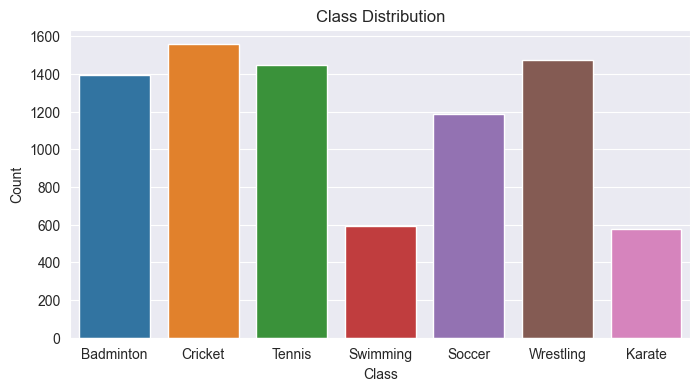

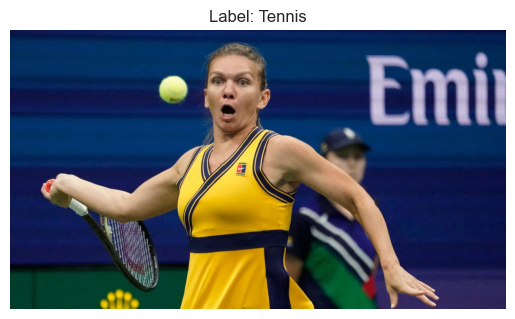

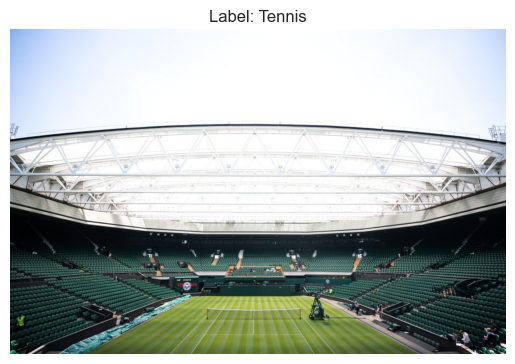

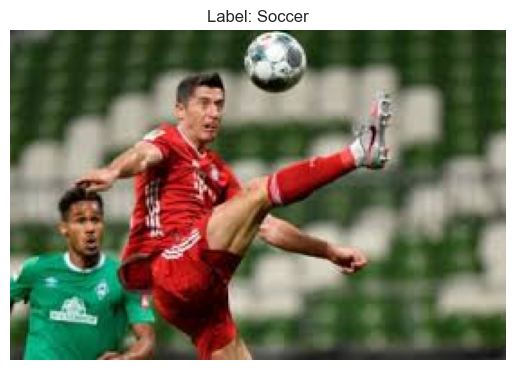

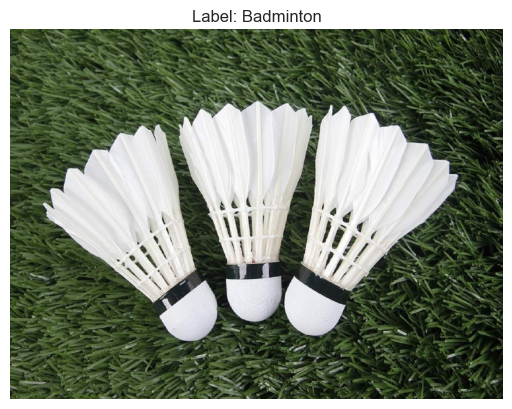

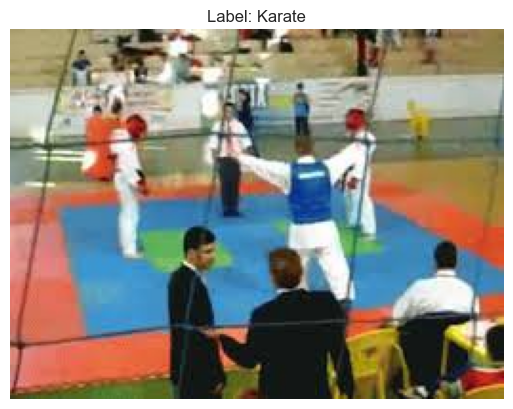

In [23]:
# Step 4: Explore data distribution and view sample images (EDA)

print("Label counts:")
print(df['label'].value_counts())

plt.figure(figsize=(8, 4))
class_labels = sorted(df['label'].unique())
palette = sns.color_palette("tab10", len(class_labels))  # tab10 gives 10 distinct colors

sns.countplot(x='label', data=df, palette=palette)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

sample_imgs = df.sample(5, random_state=42)
for idx, row in sample_imgs.iterrows():
    img = Image.open(os.path.join(img_folder, row['image_ID']))
    plt.imshow(img)
    plt.title(f"Label: {row['label']}")
    plt.axis('off')
    plt.show()


### Step 5: Define Data Transformations

In [24]:
# Step 5: Define data transformations (resize, augment, normalize)

# These are standard ImageNet mean and std, good for pre-trained models
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Data augmentation for training set (helps model generalize better)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize all images to 224x224
    transforms.RandomHorizontalFlip(),     # Randomly flip images
    transforms.RandomRotation(10),         # Randomly rotate images +/- 10 degrees
    transforms.ToTensor(),                 # Convert to PyTorch tensor
    transforms.Normalize(mean, std)        # Normalize using mean and std
])

# No augmentation for validation/test, only resizing and normalization
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Resize all images
    transforms.ToTensor(),                 # Convert to tensor
    transforms.Normalize(mean, std)        # Normalize
])


### Step 6: Split Data, Create Datasets, and DataLoaders

In [25]:
# Step 6: Split the dataset into train, validation, and test sets, and create DataLoaders

# Split: 15% for test, 15% for val (rest for train)
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['label'], random_state=42)
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


# Use img_folder for all sets
train_dataset = SportsDataset(train_df, img_folder, transform=train_transform)
val_dataset = SportsDataset(val_df, img_folder, transform=val_test_transform)
test_dataset = SportsDataset(test_df, img_folder, transform=val_test_transform)

# Create DataLoaders (can change batch size in grid search)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Train: 5757, Val: 1235, Test: 1235


### Step 7: Model Definition Function (for Grid Search)

In [27]:
# Step 7: Load Pretrained ResNet-50 and Modify Last Layer

def get_model(num_classes=None):
    # Load ResNet-50 with pretrained ImageNet weights
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

    # Freeze all layers so only the final layer trains
    for param in model.parameters():
        param.requires_grad = False

    # Get number of input features to final (fc) layer
    num_features = model.fc.in_features

    # If num_classes not given, default to 7 (your original classes)
    if num_classes is None:
        num_classes = 7

    # Replace the last layer so it matches your number of classes
    model.fc = nn.Linear(num_features, num_classes)

    # Only train the final (fc) layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)


### Step 8: Hyperparameter Tuning (Grid Search Example)

In [28]:
# Step 8: Hyperparameter Tuning (Grid Search Example)

import itertools

# Use a small subset of data for fast hyperparameter tuning
hp_frac = 0.3  # 30% subset of the data
quick_train = train_df.sample(frac=hp_frac, random_state=0)
quick_val = val_df.sample(frac=hp_frac, random_state=0)

quick_train_dataset = SportsDataset(quick_train, img_folder, transform=train_transform)
quick_val_dataset = SportsDataset(quick_val, img_folder, transform=val_test_transform)

learning_rates = [0.02, 0.01, 0.005, 0.002, 0.001, 0.0005]
batch_sizes = [16, 32]
optimizers = ['adam', 'sgd']

results = []

for lr, batch_size, opt_name in itertools.product(learning_rates, batch_sizes, optimizers):
    print(f"\nTrying: lr={lr}, batch_size={batch_size}, optimizer={opt_name}")

    # Always use correct number of classes for output layer
    model = get_model(num_classes=len(train_df['label'].unique()))
    train_loader_hp = DataLoader(quick_train_dataset, batch_size=batch_size, shuffle=True)
    val_loader_hp = DataLoader(quick_val_dataset, batch_size=batch_size, shuffle=False)

    if opt_name == 'adam':
        optimizer = optim.Adam(model.fc.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)

    criterion = nn.CrossEntropyLoss()
    num_epochs = 1  # Keep small for speed

    best_val_acc = 0
    for epoch in range(num_epochs):
        model.train()
        for images, labels in train_loader_hp:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader_hp:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_acc = val_correct / val_total
        if val_acc > best_val_acc:
            best_val_acc = val_acc

    results.append({
        "learning_rate": lr,
        "batch_size": batch_size,
        "optimizer": opt_name,
        "best_val_accuracy": best_val_acc
    })
    print(f"Best val accuracy: {best_val_acc:.4f}")

# Show the hyperparameter search results
hp_results = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(hp_results)



Trying: lr=0.02, batch_size=16, optimizer=adam
Best val accuracy: 0.7568

Trying: lr=0.02, batch_size=16, optimizer=sgd
Best val accuracy: 0.6135

Trying: lr=0.02, batch_size=32, optimizer=adam
Best val accuracy: 0.7514

Trying: lr=0.02, batch_size=32, optimizer=sgd
Best val accuracy: 0.7730

Trying: lr=0.01, batch_size=16, optimizer=adam
Best val accuracy: 0.6946

Trying: lr=0.01, batch_size=16, optimizer=sgd
Best val accuracy: 0.8108

Trying: lr=0.01, batch_size=32, optimizer=adam
Best val accuracy: 0.7351

Trying: lr=0.01, batch_size=32, optimizer=sgd
Best val accuracy: 0.7757

Trying: lr=0.005, batch_size=16, optimizer=adam
Best val accuracy: 0.7135

Trying: lr=0.005, batch_size=16, optimizer=sgd
Best val accuracy: 0.7676

Trying: lr=0.005, batch_size=32, optimizer=adam
Best val accuracy: 0.8054

Trying: lr=0.005, batch_size=32, optimizer=sgd
Best val accuracy: 0.8162

Trying: lr=0.002, batch_size=16, optimizer=adam
Best val accuracy: 0.7622

Trying: lr=0.002, batch_size=16, optim

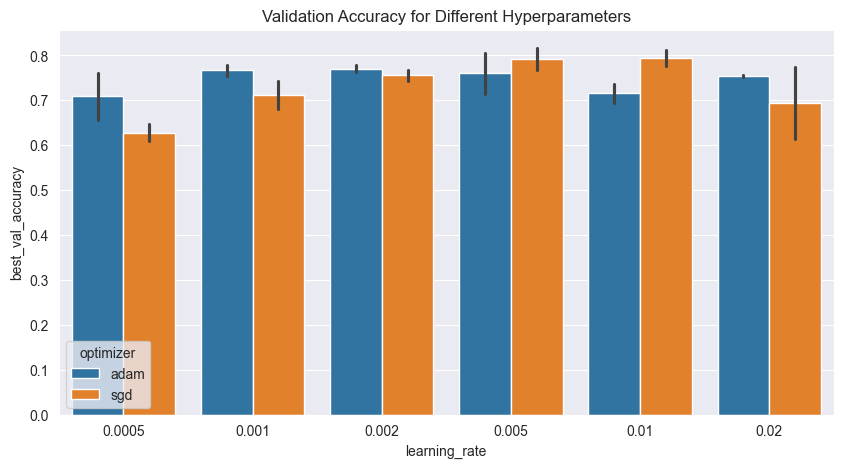

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    x="learning_rate", y="best_val_accuracy",
    hue="optimizer", data=hp_results
)
plt.title("Validation Accuracy for Different Hyperparameters")
plt.show()


### Step 9: Train the Final Model (with Best Hyperparameters)

In [31]:
# Step 9: Train the Final Model (with Best Hyperparameters)

# Best hyperparameters found in grid search
best_lr = 0.01
best_batch_size = 16
best_optimizer = 'sgd'

# Always specify num_classes for robustness
model = get_model(num_classes=len(train_dataset.label_names))

# Use best batch size for loaders
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, shuffle=False)

# Set optimizer based on best hyperparameters
if best_optimizer == 'adam':
    optimizer = optim.Adam(model.fc.parameters(), lr=best_lr)
else:
    optimizer = optim.SGD(model.fc.parameters(), lr=best_lr, momentum=0.9)

criterion = nn.CrossEntropyLoss()

num_epochs = 10   # Can be set higher for early stopping
patience = 3      # Stop if no val acc improvement in 3 epochs

train_losses, val_losses = [], []
best_val_acc = 0
epochs_no_improve = 0  # Counts epochs with no val acc improvement

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    # Validation step
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_loss = val_loss / val_total
    val_acc = val_correct / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early stopping: save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pt')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        print(f"No improvement in val acc for {epochs_no_improve} epoch(s).")
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. Best val acc: {best_val_acc:.4f}")
            break

print("Training finished! Best validation accuracy: {:.4f}".format(best_val_acc))


Epoch 1/10 | Train Loss: 0.9689, Train Acc: 0.7030 | Val Loss: 0.8088, Val Acc: 0.7854
Epoch 2/10 | Train Loss: 0.7089, Train Acc: 0.7929 | Val Loss: 0.5858, Val Acc: 0.8437
Epoch 3/10 | Train Loss: 0.6746, Train Acc: 0.8023 | Val Loss: 0.5028, Val Acc: 0.8648
Epoch 4/10 | Train Loss: 0.6584, Train Acc: 0.8025 | Val Loss: 0.9274, Val Acc: 0.7951
No improvement in val acc for 1 epoch(s).
Epoch 5/10 | Train Loss: 0.6477, Train Acc: 0.8232 | Val Loss: 0.9674, Val Acc: 0.7927
No improvement in val acc for 2 epoch(s).
Epoch 6/10 | Train Loss: 0.7035, Train Acc: 0.8131 | Val Loss: 0.4004, Val Acc: 0.8980
Epoch 7/10 | Train Loss: 0.6155, Train Acc: 0.8293 | Val Loss: 0.5552, Val Acc: 0.8575
No improvement in val acc for 1 epoch(s).
Epoch 8/10 | Train Loss: 0.6408, Train Acc: 0.8367 | Val Loss: 0.4377, Val Acc: 0.8834
No improvement in val acc for 2 epoch(s).
Epoch 9/10 | Train Loss: 0.6359, Train Acc: 0.8359 | Val Loss: 0.4388, Val Acc: 0.8866
No improvement in val acc for 3 epoch(s).
Early s

### Step 10: Evaluate Model (Classification Report & Confusion Matrix)

C:\Users\fahad\AppData\Local\Temp\ipykernel_20960\815710426.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Classification Report:
              precision    recall  f1-score   support

   Badminton       0.90      0.88      0.89       209
     Cricket       0.90      0.94      0.92       234
      Karate       0.77      0.91      0.83        87
      Soccer       0.93      0.84      0.88       178
    Swimming       0.96      0.90      0.93        89
      Tennis       0.89      0.85      0.87       217
   Wrestling       0.92      0.96      0.94       221

    accuracy                           0.90      1235
   macro avg       0.89      0.90      0.89      1235
weighted avg       0.90      0.90      0.90      1235



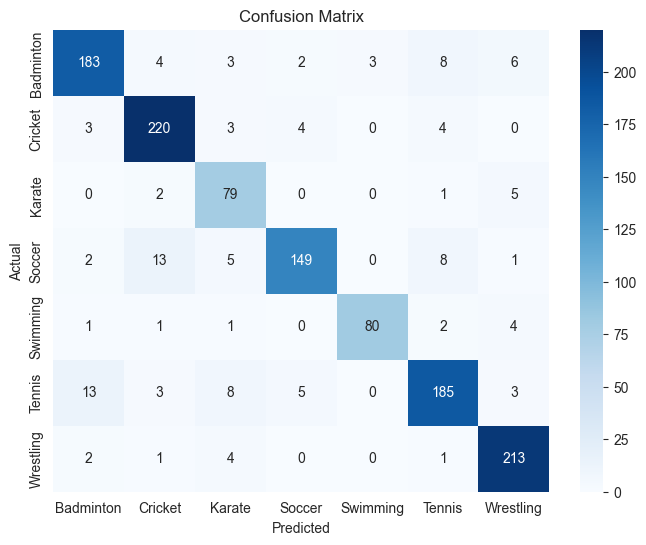

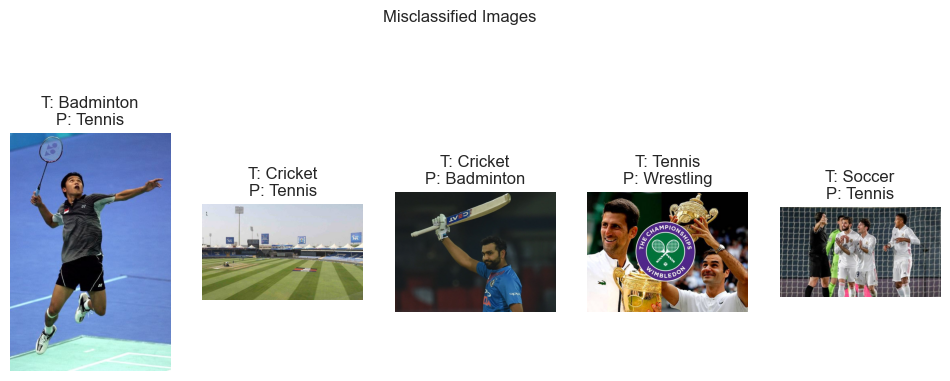

In [32]:
# Step 10: Evaluate Model (Classification Report & Confusion Matrix with Class Names)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image

# Load best model and put in evaluation mode
model.load_state_dict(torch.load('best_model.pt'))
model = model.to(device)
model.eval()

# Get predictions and labels from the validation set
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report with class names
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=val_dataset.label_names))

# Confusion matrix with class labels
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=val_dataset.label_names,
            yticklabels=val_dataset.label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize up to 5 misclassified images
mis_idx = np.where(np.array(all_preds) != np.array(all_labels))[0]
if len(mis_idx) > 0:
    plt.figure(figsize=(12, 5))
    for i, idx in enumerate(mis_idx[:5]):
        img_name = val_dataset.data.iloc[idx, 0]
        img_path = os.path.join(img_folder, img_name)
        img = Image.open(img_path)
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        true_label = val_dataset.idx2label[all_labels[idx]]
        pred_label = val_dataset.idx2label[all_preds[idx]]
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis('off')
    plt.suptitle("Misclassified Images")
    plt.show()
else:
    print("No misclassified images found.")


### Step 11: Predict on Test Set

C:\Users\fahad\AppData\Local\Temp\ipykernel_20960\77419588.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Test Accuracy: 0.8964
              precision    recall  f1-score   support

   Badminton       0.88      0.88      0.88       209
     Cricket       0.89      0.92      0.91       234
      Karate       0.78      0.94      0.85        87
      Soccer       0.92      0.86      0.89       178
    Swimming       1.00      0.93      0.97        89
      Tennis       0.89      0.83      0.86       217
   Wrestling       0.92      0.95      0.94       221

    accuracy                           0.90      1235
   macro avg       0.90      0.90      0.90      1235
weighted avg       0.90      0.90      0.90      1235



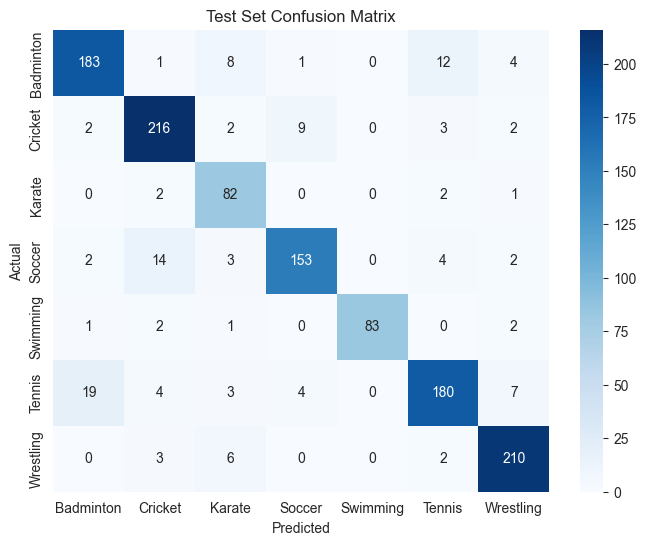

In [34]:
# Step 11: Final Model Testing on Test Set (Labeled)

test_dataset = SportsDataset(test_df, img_folder, transform=val_test_transform, is_test=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.load_state_dict(torch.load('best_model.pt'))
model.eval()

test_preds = []
test_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# Accuracy and full report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

test_acc = accuracy_score(test_labels, test_preds)
print(f"Test Accuracy: {test_acc:.4f}")
print(classification_report(test_labels, test_preds, target_names=test_dataset.label_names))

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_dataset.label_names, yticklabels=test_dataset.label_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Set Confusion Matrix')
plt.show()


### Step 12: Plot Training and Validation Loss Curves

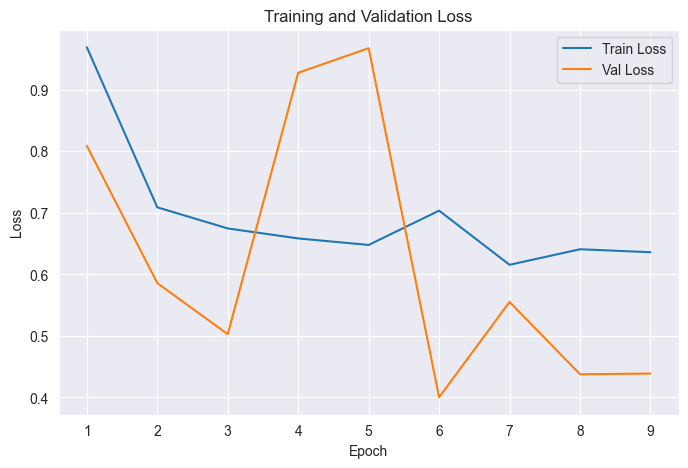

In [36]:
# Step 12: Plot Training and Validation Loss Curves

plt.figure(figsize=(8, 5))

# x-axis matches number of epochs actually run (not num_epochs, which is max)
epochs_run = len(train_losses)
plt.plot(range(1, epochs_run + 1), train_losses, label='Train Loss')
plt.plot(range(1, epochs_run + 1), val_losses, label='Val Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.grid(True)
plt.show()
